In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn import model_selection
import seaborn as sns
import random

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
def show_correlation_coefficient(data_df,method):
    sns.set(font_scale=1)
    df_corr = data_df.corr(method=method, min_periods=1)
    plt.figure(figsize=(18,14))
    sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot=True,
            linewidths=0.5)

In [3]:
def show_distribution_diagram(data, name):
    sns.set(font_scale=1)
    variable = data[name].fillna(data.mean())
    sns.displot(data=variable, kind="kde", multiple="stack")
    plt.show()

In [5]:
class YieldStressPredict:
    def __init__(self, params):
        self.params = params
        self.reg = ensemble.GradientBoostingRegressor(**params)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.reg.fit(self.X_train, self.y_train)

    def predict(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_predict = self.reg.predict(X_test)

    def get_mean_squared_error(self):
        mse = mean_squared_error(self.y_test, self.y_predict)
        return mse
    def get_mean_absolute_error(self):
        mae = mean_absolute_error(self.y_test,self.y_predict)
        return  mae
    def get_r2_score(self):
        r2 = r2_score(self.y_test, self.y_predict)
        return r2

    def show_deviance_diagrams(self,model_name):
        test_score = np.zeros((self.params["n_estimators"],), dtype=np.float64)
        for i, y_pred in enumerate(self.reg.staged_predict(self.X_test)):
            test_score[i] = self.reg.loss_(self.y_test, y_pred)

        fig = plt.figure(figsize=(6, 6))
        plt.subplot(1, 1, 1)
        plt.title("Deviance of: " + model_name)
        plt.plot(
            np.arange(self.params["n_estimators"]) + 1, self.reg.train_score_, "b-", label="Training Set Deviance", )
        plt.plot(np.arange(self.params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
        plt.legend(loc="upper right")
        plt.xlabel("Boosting Iterations")
        plt.ylabel("Deviance")
        fig.tight_layout()
        plt.show()

    def show_features_importance(self,model_name):
        feature_names = self.X_train.columns
        feature_importance = self.reg.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(feature_names)[sorted_idx])
        plt.title("Feature Importance (MDI) of: " + model_name)

        result = permutation_importance(
            self.reg, self.X_test, self.y_test, n_repeats=10, random_state=13, n_jobs=2
        )
        sorted_idx = result.importances_mean.argsort()
        plt.subplot(1, 2, 2)
        plt.boxplot(
            result.importances[sorted_idx].T,
            vert=False,
            labels=np.array(feature_names)[sorted_idx],
        )
        plt.title("Permutation Importance (test set)")
        fig.tight_layout()
        plt.show()


def train_test_split(data_df, target_feature_name, test_size, random_state):
    X = data_df.drop([target_feature_name], axis=1)
    y = data_df[target_feature_name]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_train, X_test, y_train, y_test)




	
    

In [5]:
def compare_models(models, data_df, target_feature, test_size, number_of_iterations):
    csv_files = [0] * len(models)
    header = "Times,MAE,MSE,R2,random_state\n"
    for i in range(len(models)):
        csv_files[i] = models[i]['name']
        with open(csv_files[i], "w+") as f:
            f.write(header)
    for i in range(number_of_iterations):
        random_state = random.randint(1,12341251)
        X_train, X_test, y_train, y_test = train_test_split(data_df, target_feature, test_size, random_state)

        for j in range(len(models)):
            reg = models[j]['reg']
            # traings model
            reg.fit(X_train, y_train)
            # predict test data
            reg.predict(X_test, y_test)
            mae = reg.get_mean_absolute_error()
            mse = reg.get_mean_squared_error()
            r2 = reg.get_r2_score()
            newline = "{},{},{},{},{}\n".format(i,mae, mse, r2,random_state)
            with open(csv_files[j], 'a') as f:
                f.write(newline)
    return models
            

In [17]:
filename = "YieldStress_database.csv"
target_feature = "YS (MPa)"
data_df = pd.read_csv(filename)
data_df = data_df.iloc[:, 1:]



In [ ]:
show_correlation_coefficient(data_df=data_df.drop([target_feature],axis = 1),method = "pearson")

In [7]:
show_distribution_diagram(data_df,target_feature)

In [8]:
params_gaussian_error = {
    "learning_rate": 0.01,
    "loss": "squared_error",
    "max_depth": 20,
    "min_samples_leaf": 4,
    "min_samples_split": 2,
    "n_estimators": 1500,
    "subsample": 0.9,
    "n_iter_no_change" : 1200,
    "validation_fraction":0.15,

}
params_laplace_error = {
    "learning_rate": 0.01,
    "loss": "absolute_error",
    "max_depth": 20,
    "min_samples_leaf": 4,
    "min_samples_split": 2,
    "n_estimators": 1500,
    "subsample": 0.9,
    "n_iter_no_change" : 1200,
    "validation_fraction":0.15,

}
model_gaussian_error = YieldStressPredict(params_gaussian_error)
name1 = 'gaussian_error_boosting.csv'
name2 = 'laplace_error_boosting.csv'
model_laplace_error = YieldStressPredict(params_laplace_error)
all_models = [{'reg': model_gaussian_error,
               'name': name1},
              {'reg': model_laplace_error,
               'name': name2}
              ]

In [ ]:
all_models = compare_models(all_models, data_df, target_feature, 0.3, 200)

/opt/python/envs/default/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


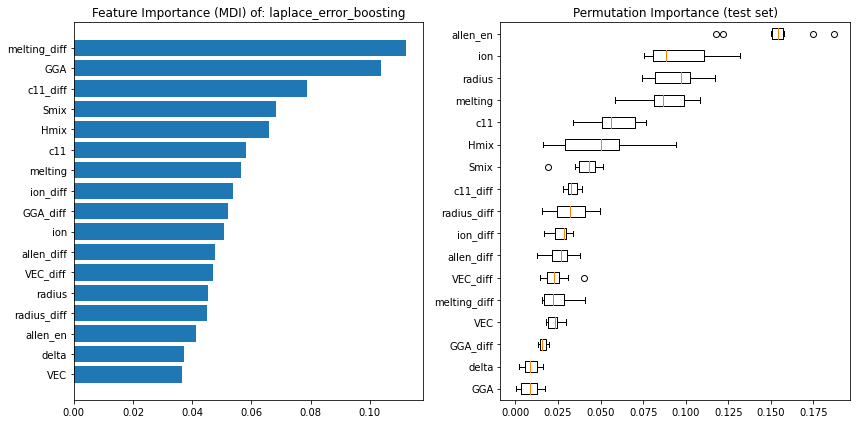

In [18]:
for i in all_models:
    df = pd.read_csv(i['name'])
    random_state_index = df['R2'].idxmax()
    
    random_state = df['random_state'][random_state_index]
    X_train,X_test,y_train,y_test = train_test_split(data_df, target_feature, 0.3, random_state)
    reg = i['reg']
    reg.fit(X_train,y_train)
    reg.predict(X_test,y_test)
    reg.show_deviance_diagrams(i['name'].split('.csv')[0])
    print()
    reg.show_features_importance(i['name'].split('.csv')[0])




In [23]:
from matplotlib.ticker import FuncFormatter


def show_diagram_two_model(model_name_1, model_name_2, filename1, filename2,number_point,aspect,height):
    result1 = pd.read_csv(filename1)
    result2 = pd.read_csv(filename2)
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    for i in range(1, len(result1.columns)-1):
        property_name = result1.columns[i]
        df = pd.DataFrame()
        df['Time'] = []
        df[property_name] = []
        df['Model'] = []
        list1 = result1[property_name].to_list()
        list2 = result2[property_name].to_list()
        for j in range(number_point):
            df = df.append({'Time': int(j), property_name: list1[j], 'Model': model_name_1}, ignore_index=True)
            df = df.append({'Time': int(j), property_name: list2[j], 'Model': model_name_2}, ignore_index=True)
        df.to_csv(property_name + "_merge.csv")
        g = sns.catplot(data=df, kind="point", x='Time', y=property_name, hue='Model', ci=None, palette="dark", aspect=aspect, height=aspect)
        ax = g.fig.gca()
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    
    

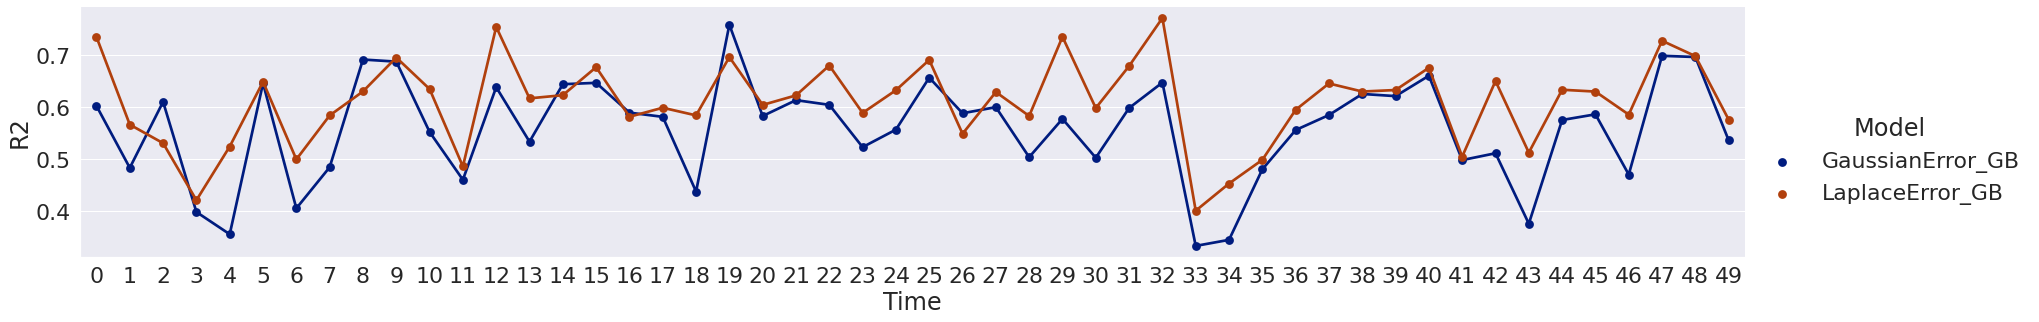

In [24]:
show_diagram_two_model('GaussianError_GB','LaplaceError_GB',name1,name2,50,5,5)